In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:35379 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

13.285846710205078


# Prepare data for processing

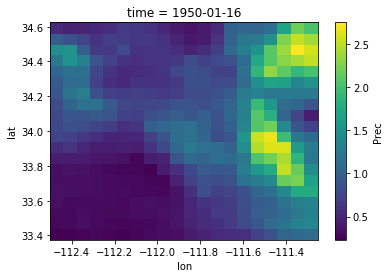

In [79]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(300,320), lon=slice(200,220), time=slice(0,60))
#ds2 = ds.isel(time=slice(0,60))
ds2.Prec.isel(time=0).load()
ds2.Prec.isel(time=0).plot()

In [80]:
#Set the number of bins we want to have for our data
bin_number = 2**8

In [114]:
#Stack the data along the space time axis
ds3 = ds2.stack(points=['lon','lat','time'])

In [115]:
ds3.Prec

<xarray.DataArray 'Prec' (points: 24000)>
dask.array<shape=(24000,), dtype=float32, chunksize=(1200,)>
Coordinates:
  * points   (points) MultiIndex
  - lon      (points) float64 -112.5 -112.5 -112.5 -112.5 -112.5 -112.5 ...
  - lat      (points) float64 33.41 33.41 33.41 33.41 33.41 33.41 33.41 ...
  - time     (points) datetime64[ns] 1950-01-16 1950-02-14T12:00:00 ...
Attributes:
    units:     mm
    longname:  Precipitation

# Quantize the data

In [116]:
#Shape the data
shape = da.stack([ds3.Prec.data, ds3.Tmax.data, ds3.Tmin.data])
shape = da.transpose(shape)
shape

dask.array<transpose, shape=(24000, 3), dtype=float32, chunksize=(1200, 1)>

In [117]:
#Build the histogram
H = np.histogramdd(shape, bins=bin_number)
data_quant = H[0]

# Compute DWT

In [131]:
#Set the number of levels for DWT, as well as the wavelet
levels = 3
wave = 'bior2.2'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = bin_number , filter_len = pywt.Wavelet(wave).dec_len) 

In [132]:
#Perform dwt on quantized data.
wp = pywt.wavedecn(data=data_quant, wavelet=wave, level = min(levels,max_level))
#wp = pywt.dwtn(data=data_quant, wavelet=wave)

In [133]:
wp[0].shape

(36, 36, 36)

In [134]:
#View the distribution of the DWT values
np.histogram(wp[0], bins=100)

(array([    1,     2,     3,     5,    35,   245, 45244,   432,   171,
          100,    68,    42,    44,    22,    16,    17,    16,    17,
           20,    12,     2,     9,    14,     9,     8,    10,     7,
            2,     3,     5,     3,     3,     1,     4,     2,     1,
            3,     3,     0,     2,     1,     7,     1,     3,     3,
            3,     3,     1,     3,     2,     1,     3,     2,     1,
            0,     1,     0,     1,     1,     0,     0,     1,     0,
            1,     0,     0,     2,     0,     0,     1,     0,     1,
            0,     0,     0,     1,     2,     1,     0,     0,     0,
            2,     0,     0,     0,     0,     1,     1,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            1]),
 array([-2.92759377, -2.46681685, -2.00603993, -1.545263  , -1.08448608,
        -0.62370916, -0.16293224,  0.29784468,  0.75862161,  1.21939853,
         1.68017545,  2.14095237,  2.60172929,  3.062506

# Threshold the results of DWT

In [135]:
#Pick a threshold value.  
# For climate data, we probably only want the approximate (low frequency) coefficents to cluster. 
epsilon = .0001

In [136]:
#Threshold the DWT
wp[0][abs(wp[0])<epsilon] = 0
wp[0][abs(wp[0])>=epsilon] = 1

In [137]:
#View the distribution of the threshold DWT values
np.histogram(wp[0], bins=100)

(array([39311,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         7345]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

# Find connected components

In [138]:
#Compute the connected components of each thresholed DWT.  Adjacnecy is determined by ``four'' connectivity.
component = ndimage.label(wp[0])[0]

In [140]:
np.histogram(component, bins=3)

(array([39311,  7339,     6]), array([0., 1., 2., 3.]))

In [ ]:
#Remove components that have a small number of points in them?

In [139]:
#Check number of connected components
np.max(component)

3

# Create lookup Table

In [168]:
#The following lookup table is only built to handle the Haar wavelet.
#First, label data_quant classes
classes = np.repeat(component, levels + 1)

if data_quant.size % 2 ==1:  #If odd number of elements in array, need to deal with right endpoint
    classes = classes[:-1]

In [170]:
classes.shape

(4194304,)